<a href="https://colab.research.google.com/github/manishanandyadav666/Application/blob/main/UG_Mines_testing_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install stable-baselines3[extra]

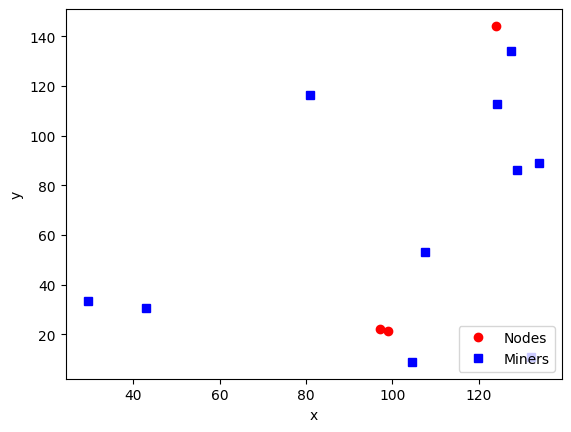

Inside the distribute_miner function
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
The change in battery level is:  [-42 -56 -12]
Inside get_state funciton
The state is:  [[  0   3 -42]
 [  0   3 -56]
 [  0   4 -12]]
Now the reward is:  -168.13333333333333
The runtime is:  10111
Now the action is:  [22 52 82]
Inside battery decay function
The change in battery level is:  [-22 -52 -82]
Inside get_state funciton
The state is:  [[  0   3 -22]
 [  0   3 -52]
 [  0   4 -82]]
Now the reward is:  -330.4
The runtime is:  10112
Now the action is:  [17 98 13]
Inside battery decay function
The change in battery level is:  [-17 -98 -13]
Inside get_state funciton
The state is:  [[  0   3 -17]
 [  0   3 -98]
 [  0   4 -13]]
Now the reward is:  -335.4
The runtime is:  10113
Now the action is:  [68 97 39]
Inside battery decay function
The change in battery level is:  [-68 -97 -39]
Inside get_state funciton
The state is:  [[  0   3 -68]
 [  0   3 -97]
 [  0   4 -39]]
Now the reward is:  -518.4666666666666
The runtime is:  10114
Now t

KeyboardInterrupt: 

In [2]:
import math
import gym
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt


class MineEnvironment(gym.Env):
    def __init__(self, initial_battery_levels, total_miners):
        super(MineEnvironment, self).__init__()

        self.initial_battery_levels = initial_battery_levels
        self.actual_battery_levels = initial_battery_levels.copy()
        self.num_sensor_nodes = len(initial_battery_levels)
        self.total_miners = total_miners

        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)
        #self.num_miners_list = self.distribute_miners()
        self.battery_change = np.zeros_like(self.initial_battery_levels)

        self.action_space = gym.spaces.MultiDiscrete([101] * self.num_sensor_nodes)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(self.num_sensor_nodes, 3), dtype=np.float32)

        self.abl = initial_battery_levels.copy()
        self.pdl = self.predicted_battery_levels.copy()

        self.action_array = np.empty((0, self.num_sensor_nodes))
        self.reward_list = []
        self.error = []
        self.runtime = 0

        ### Location of the miners
        self.miners_loc_x = np.zeros(self.total_miners)
        self.miners_loc_y = np.zeros(self.total_miners)
        #self.build_location(self.num_sensor_nodes, total_miners)
         #Initialize node and miner locations
        self.build_location(self.num_sensor_nodes, total_miners)
        self.num_miners_list = self.distribute_miners()

    def build_location(self, nodes, miners):
        self.nodes = nodes
        self.miners = miners
        self.nodes_loc_x = np.random.uniform(0, 150, self.nodes)
        self.nodes_loc_y = np.random.uniform(0, 150, self.nodes)
        self.miners_loc_x = np.random.uniform(0, 150, self.miners)
        self.miners_loc_y = np.random.uniform(0, 150, self.miners)

        self.nodes_miners_d = np.zeros((self.nodes, self.miners))
        for k in range(self.nodes):
            for l in range(self.miners):
                self.nodes_miners_d[k][l] = np.sqrt(
                    np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                    np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

        plt.plot(self.nodes_loc_x, self.nodes_loc_y, 'ro', label='Nodes')
        plt.plot(self.miners_loc_x, self.miners_loc_y, 'bs', label='Miners')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()

    def calculate_energy(self, d):

        k = 10  # Number of bits
        r_c = 80  # Communication range
        epsilon_elec = 50e-9  # Energy to run transmitter/receiver
        epsilon_fs = 10e-12  # Energy for short distance
        epsilon_mp = 0.0013e-12  # Energy for long distance
        d_o = math.sqrt(epsilon_fs / epsilon_mp)
        E_t=0
        E_r=0
        if d <= d_o <= r_c:
            E_t = k * epsilon_elec + k * epsilon_fs * d**2
        elif d_o <= d <= r_c:
            E_t = k * epsilon_elec + k * epsilon_mp * d**4
        elif d > r_c:
            E_t = 0
        E_r = k * epsilon_elec
        return E_t, E_r

    def reset(self):
        self.actual_battery_levels = self.initial_battery_levels.copy()
        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)
        self.num_miners_list = self.distribute_miners()
        self.battery_change = np.zeros_like(self.initial_battery_levels)
        return self.get_state()

    def step(self, action):
        print('The runtime is: ', self.runtime)
        self.runtime += 1
        if self.runtime % 5000 == 0:
            self.num_miners_list = self.distribute_miners()
        print('Now the action is: ', action)
        self.take_action(action)
        self.abl = np.column_stack((self.abl, self.actual_battery_levels))
        self.pdl = np.column_stack((self.pdl, self.predicted_battery_levels))
        state = self.get_state()
        reward = self.get_reward()
        print('Now the reward is: ', reward)
        self.reward_list.append(reward)
        done = False
        info = {}
        return state, reward, done, info

    def get_state(self):
        print('Inside get_state funciton')
        state = np.column_stack((self.actual_battery_levels, self.num_miners_list, self.battery_change))
        print("The state is: ", state)
        return state

    def distribute_miners(self):
      print("Inside the distribute_miner function")
      new_miners_loc_x = np.zeros(self.total_miners)
      new_miners_loc_y = np.zeros(self.total_miners)
      for i in range(self.total_miners):
          if np.random.rand() < 0.8:  # 80% chance to stay in the same location
              new_miners_loc_x[i] = self.miners_loc_x[i]
              new_miners_loc_y[i] = self.miners_loc_y[i]
          else:
              # 20% chance to move to a new location based on proximity
              current_x = self.miners_loc_x[i]
              current_y = self.miners_loc_y[i]
              distances = np.sqrt(np.power(self.nodes_loc_x - current_x, 2) + np.power(self.nodes_loc_y - current_y, 2))
              probabilities = 1 / (distances + 1e-10)  # Inverse of distance to create higher probability for closer nodes
              probabilities /= probabilities.sum()  # Normalize to create a probability distribution

              new_node_index = np.random.choice(range(self.nodes), p=probabilities)
              new_miners_loc_x[i] = self.nodes_loc_x[new_node_index]
              new_miners_loc_y[i] = self.nodes_loc_y[new_node_index]
      # Update the miner locations
      self.miners_loc_x = new_miners_loc_x
      self.miners_loc_y = new_miners_loc_y
      # Update the distance matrix
      self.nodes_miners_d = np.zeros((self.nodes, self.miners))
      for k in range(self.nodes):
          for l in range(self.miners):
              self.nodes_miners_d[k][l] = np.sqrt(
                  np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                  np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))
      # Determine the closest node for each miner
      num_miners_list = np.zeros(self.nodes, dtype=int)
      for l in range(self.miners):
          closest_node = np.argmin(self.nodes_miners_d[:, l])
          num_miners_list[closest_node] += 1

      return num_miners_list



    def calculate_battery_decay(self):
      #
      print('Inside battery decay function')
      full_energy = 10.0
      battery_capacity = 100.0
      for i in range(self.num_sensor_nodes):
          #
          total_energy_consumed = 0
          miners_connected = self.num_miners_list[i]  # Number of miners connected to this sensor node
          for miner_idx in range(self.total_miners):
              if self.num_miners_list[i] > 0:
                  # Only consider miners that are connected to this sensor node
                  d = self.nodes_miners_d[i][miner_idx]
                  E_T, E_R = self.calculate_energy(d)
                  total_energy_consumed += (E_T + E_R)
          battery_decay = (total_energy_consumed / full_energy) * battery_capacity
          self.actual_battery_levels[i] -= battery_decay
          self.actual_battery_levels[i] = np.clip(self.actual_battery_levels[i], 0, 100)


    '''def calculate_battery_decay(self):
        print('Inside battery_decay function')
        full_energy = 10.0  # Full energy in Joules
        battery_capacity = 100.0  # Full battery level in percentage

        for i in range(self.num_sensor_nodes):
            total_energy_consumed = 0
            ### Check this line again
            for miner_idx in range(self.miners):
                d = self.nodes_miners_d[i][miner_idx]
                E_T, E_R = self.calculate_energy( d)
                total_energy_consumed += (E_T + E_R)
            battery_decay = (total_energy_consumed / full_energy) * battery_capacity
            self.actual_battery_levels[i] -= battery_decay
            self.actual_battery_levels[i] = np.clip(self.actual_battery_levels[i], 0, 100)'''

    def take_action(self, action):
        self.action_array = np.vstack((self.action_array, action))
        self.predicted_battery_levels = action
        self.predicted_battery_levels = np.clip(self.predicted_battery_levels, 0, 100)
        self.calculate_battery_decay()
        self.battery_change = self.actual_battery_levels - self.predicted_battery_levels
        print('The change in battery level is: ', self.battery_change)
        self.error.append(self.battery_change)

    def get_reward(self):
        B_dt = np.abs(self.actual_battery_levels - self.predicted_battery_levels)
        rewards = [-(b_dt_value * b_dt_value) / 10 for b_dt_value in B_dt]
        return np.sum(rewards) / len(rewards)


# Initialize the parameters
initial_battery_levels = np.array([100, 100, 100])  # Initial battery levels for all sensor nodes
total_miners = 10  # Total number of miners

# Create the custom environment for multiple sensor nodes
mine_env = MineEnvironment(initial_battery_levels, total_miners)

# Create and train the PPO model
ppo_model = PPO("MlpPolicy", mine_env, verbose=1)
epochs = 200
for epoch in range(epochs):
    mine_env.reset()
    ppo_model.learn(total_timesteps=2048)

In [3]:
act_0= mine_env.action_array[0:, :]
act_1= mine_env.action_array[1:, :]
act_2= mine_env.action_array[2:, :]
rew= mine_env.reward_list

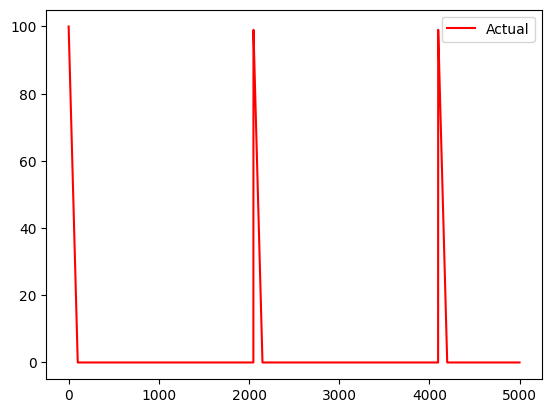

In [4]:
### Function to print graph
import matplotlib.pyplot as plt
ar_1= mine_env.abl[0,:5000]
ar_2= mine_env.pdl[0, :5000]
ac=ar_1
bl= ar_2
t= np.arange(len(ar_2))
#fig, ax = plt.subplots()
#ax.plot(t, bl)
plt.plot(t, ac, color='r', label='Actual')
#plt.plot(t, bl, color='g', label='Predicted')

#ax.set(xlabel='time_steps', ylabel='battery_level',
       #title='Actual VS Predicted')
plt.legend()
plt.show()

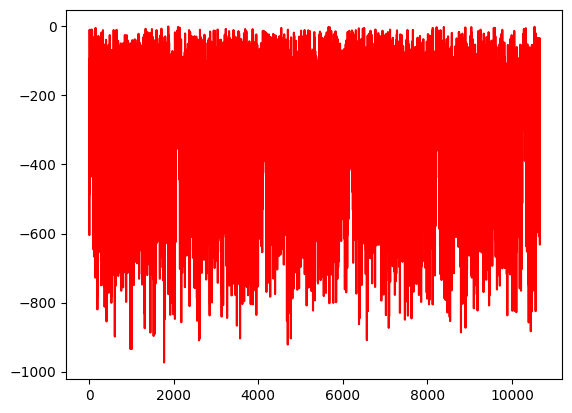

In [5]:
rew= mine_env.reward_list
rt= np.arange(len(rew))
plt.plot(rt, rew, color='r', label='rewards')

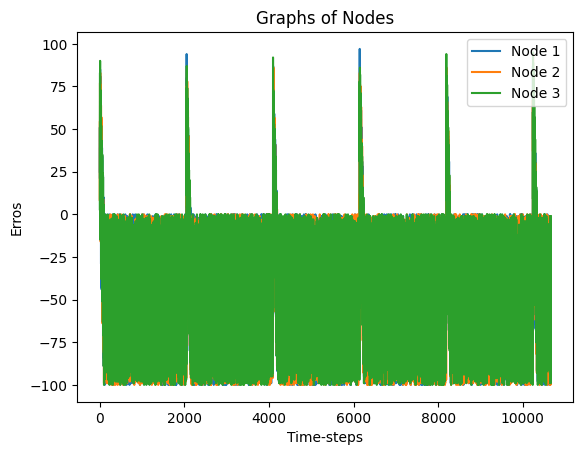

In [6]:
import matplotlib.pyplot as plt

# Your list of arrays
data = mine_env.error

# Extracting elements from each array
element1 = [arr[0] for arr in data]
element2 = [arr[1] for arr in data]
element3 = [arr[2] for arr in data]

# Generating x-values (assuming each array is evenly spaced)
x_values = list(range(len(data)))

# Plotting the graphs
plt.plot(x_values, element1, label='Node 1')
plt.plot(x_values, element2, label='Node 2')
plt.plot(x_values, element3, label='Node 3')

plt.xlabel('Time-steps')
plt.ylabel('Erros')
plt.title('Graphs of Nodes')
plt.legend()
plt.show()


In [ ]:
### Plot three graphs separately
